## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import warnings

from neural_networks.fcrn import FCRN_A
from utils.data.data_generator import DataGenerator
from utils.input_output.io import load_images_and_density_maps
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_some_predictions

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

In [4]:
params = {
    'dim': config.DIM,
    'batch_size': 1,
    'shuffle': False
}

In [5]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **params)
test_generator = DataGenerator(config.DATASET_PATH, 'test', **params)

## 3. Load the best model

In [6]:
model = FCRN_A(pretrained_weights=config.CHECKPOINT_FILENAME)

## 4. Look at some predictions (a small batch from the test set)

In [7]:
NUM_IMAGES = 3
test_images_batch, test_density_maps_batch = load_images_and_density_maps(config.TEST_PATH, NUM_IMAGES)
test_preds_batch = model.predict(np.array(test_images_batch)) / config.DENSITY_MAP_MULTIPLICATION_FACTOR

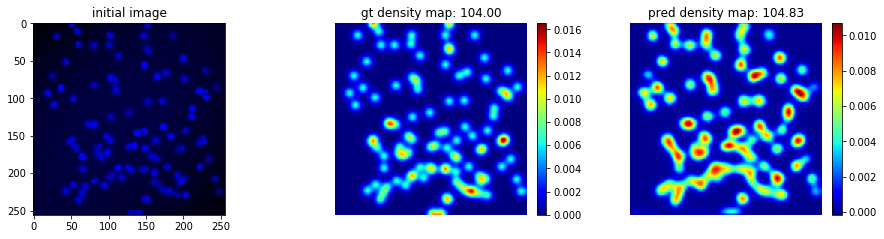

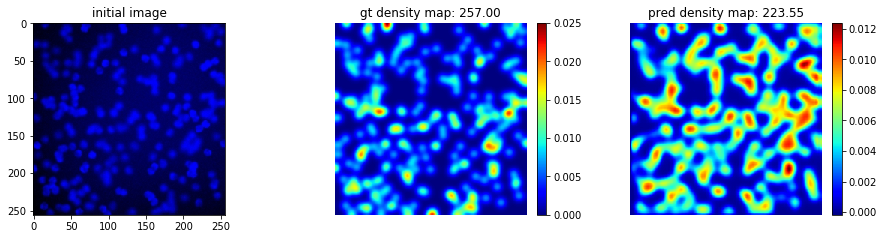

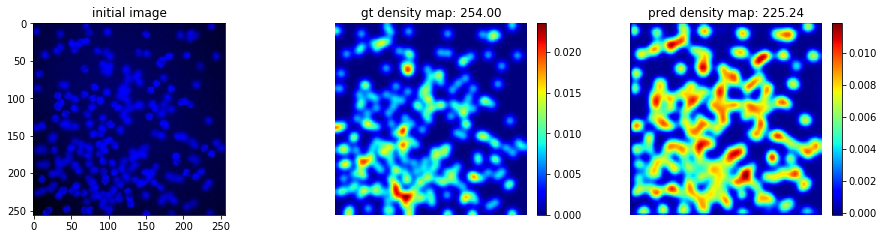

In [8]:
plot_some_predictions(test_images_batch, test_density_maps_batch, test_preds_batch)

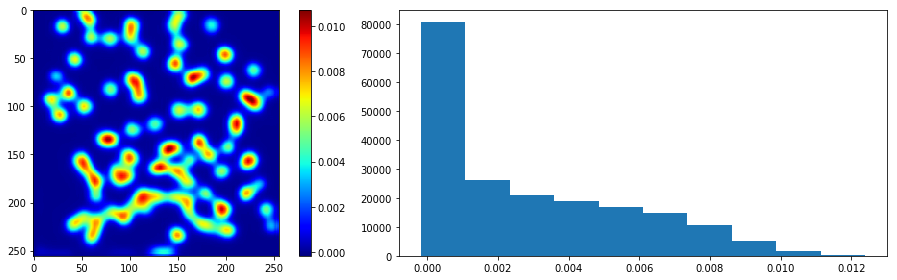

In [9]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_preds_batch.squeeze()[0], cmap='jet')
plt.colorbar(fraction=0.045, pad=0.04)
plt.subplot(1, 2, 2)
plt.hist(test_preds_batch.flatten())
plt.tight_layout()
plt.show()